In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import convolve
from scipy import ndimage
%matplotlib inline

# Question 1 - Edge detection

## Section B

    zero_crossing_pixels = []
    rows, cols = laplacian.shape
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
if (laplacian[i, j] > a and any(laplacian[i + dx, j + dy] < b for dx in [-1, 0, 1] for dy in [-1, 0, 1])) or \
               (laplacian[i, j] < b and any(laplacian[i + dx, j + dy] > a for dx in [-1, 0, 1] for dy in [-1, 0, 1])):
                zero_crossing_pixels.append((i, j))

    return zero_crossing_pixels

In [ ]:
def zero_crossing(LoG, a, b):
    """
    This function gets as input the LoG and calculates the zero crossings.
    The output is a binary matrix with 1 in all the zero crossing pixels
    and 0 otherwise.
    """
    zc = np.zeros_like(LoG)
    rows,cols = LoG.shape
    for i in range(1,rows-1):
        for j in range(1,cols-1):
            term1 = LoG[i,j] > a and any(LoG[i+dx, j+dy]<b for dx in [-1, 0, 1] for dy in [-1, 0, 1])
            term2 = LoG[i,j] < b and any(LoG[i+dx, j+dy]>a for dx in [-1, 0, 1] for dy in [-1, 0, 1])

            if term1 or term2:
                zc[i,j] = 1
    return zc # Replace with zero crossing code

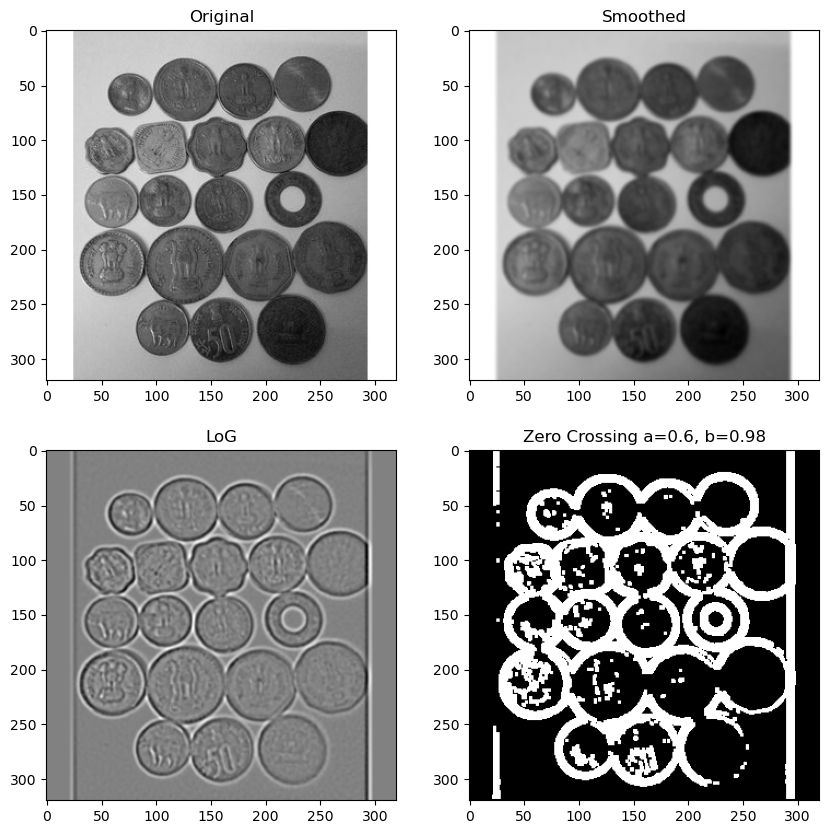

In [ ]:
##Reads the original image in grayscale, and sets the image range to be 0-1 (instead of 0-255)
coins = cv2.imread('coins_edges.jpg', cv2.IMREAD_GRAYSCALE).astype(float) / 255 #'coins': The original image in grayscale.

## Implementation of LoG as shown in tutorial #6
laplacian_kernel = np.array([
    [0, -1,  0],
    [-1, 4, -1],
    [0, -1,  0],
])
# 'smoothed': The smoothed image (i.e., the image after applying the Gaussian smoothing).
smoothed = cv2.GaussianBlur(coins, (7, 7) ,0) # You may change the 'ksize' parameter (7,7) and the sigma parameter 0.
LoG = cv2.filter2D(smoothed, ddepth=cv2.CV_64F, kernel=laplacian_kernel).astype(float) #'LoG': The image after applying LoG.
LLoG = 1 / (1 + np.abs(LoG)) #TODO: why we dont need it here?

# plot compare:
_a = 0.6
_b = 0.98
# 'zc': The image of the detected edges after applying zero-crossing.
zc = zero_crossing(LLoG,
                   a = _a,
                   b = _b) # You may change the parameters a, b to get the best result

zc_header = "Zero Crossing a={}, b={}".format(_a,_b)

# Showing the 4 plots requested in this section
_, axes = plt.subplots(2, 2, figsize=(10, 10))
for ax, img ,title in zip(axes.flatten(),
                          [coins, smoothed, LoG, zc],
                          ["Original", "Smoothed", "LoG",zc_header ]):
    ax.imshow(img,
              cmap='gray')
    ax.set_title(title)


## Section C

In [ ]:
def plot_canny_zc(low_t,high_t):
    # coins' image with added Gaussian noise
    noisy_coins = coins + np.random.standard_normal(coins.shape) * 0.05
    # low_t = 170
    # high_t = 510
    # OpenCV expects image with value range of 0 - 255
    # Therefore, for cv2 functions (such as cv2.Canny) use the following variable instead of 'noisy_coins'
    noisy_coins_uint8 = (noisy_coins * 255).astype(np.uint8)
    zc = zero_crossing(noisy_coins_uint8, low_t,high_t)
    #=============
    # Find edges in the noisy image by using
    # cv2.Canny and your method from section A. Plot the results side by side.

    canny_alg = cv2.Canny(noisy_coins_uint8,threshold1 = low_t,threshold2=high_t)

    zc_header = "Zero Crossing a={}, b={}".format(low_t,high_t)
    canny_header = "Canny EdgeDetector low_t={}, high_t={}".format(low_t,high_t)

    _, axes = plt.subplots(1, 2, figsize=(10, 10))
    for ax, img ,title in zip(axes.flatten(),
                            [ zc, canny_alg],
                            [zc_header ,canny_header]):
        ax.imshow(img,
                cmap='gray')
        ax.set_title(title)

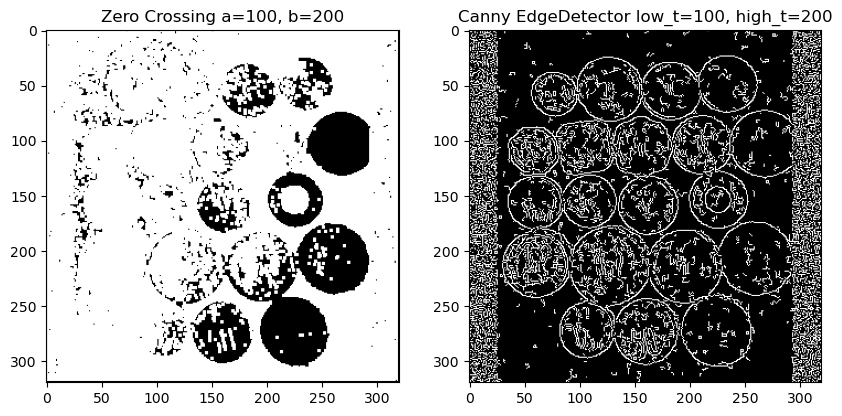

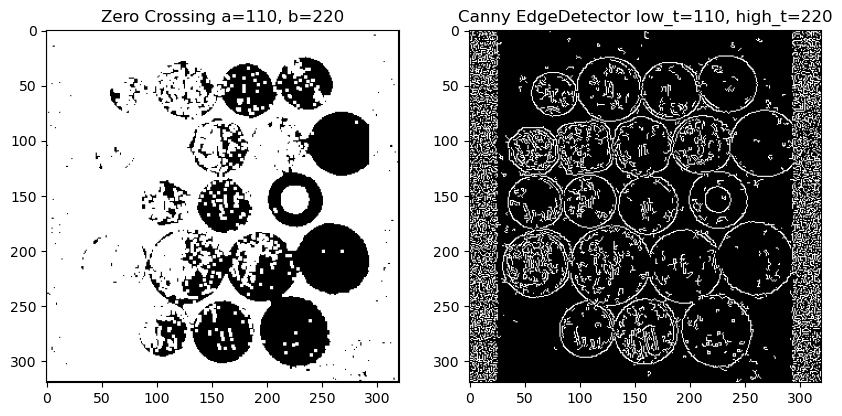

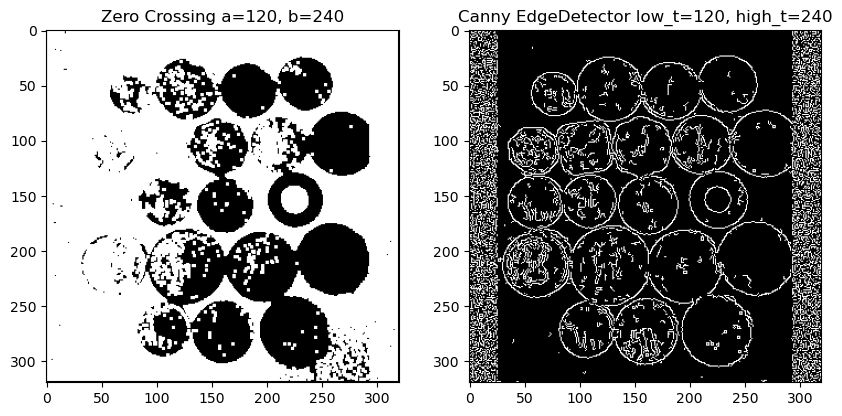

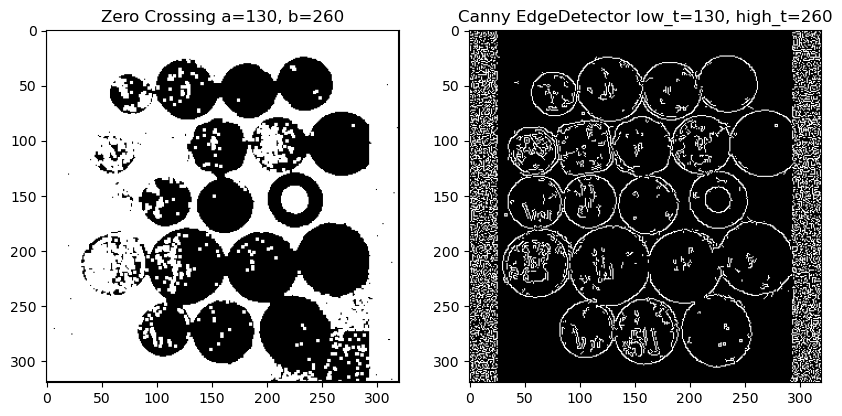

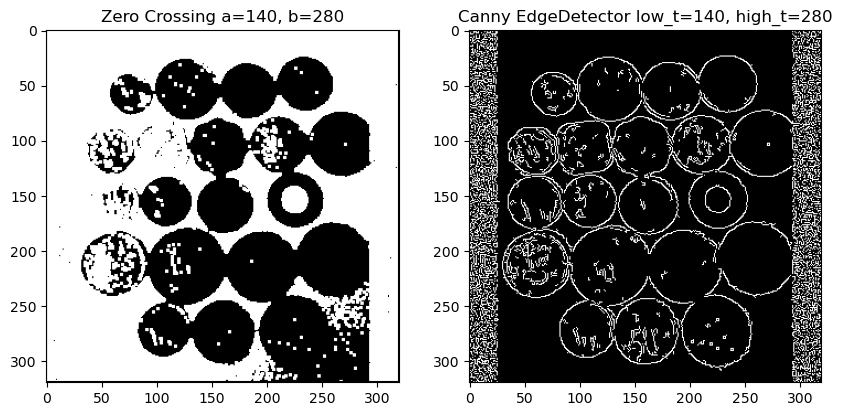

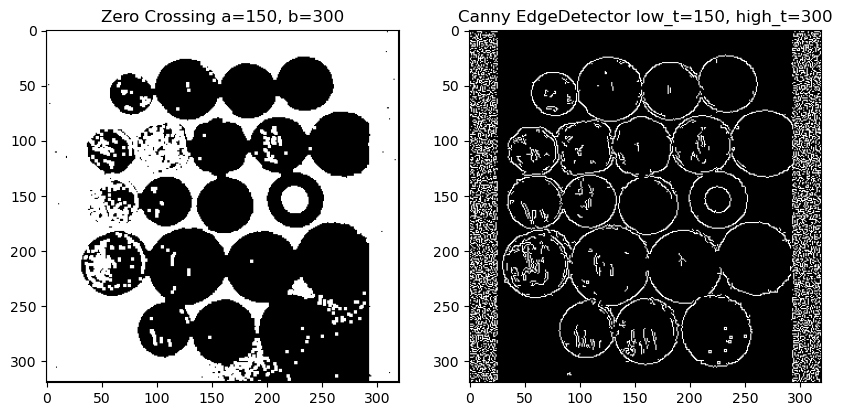

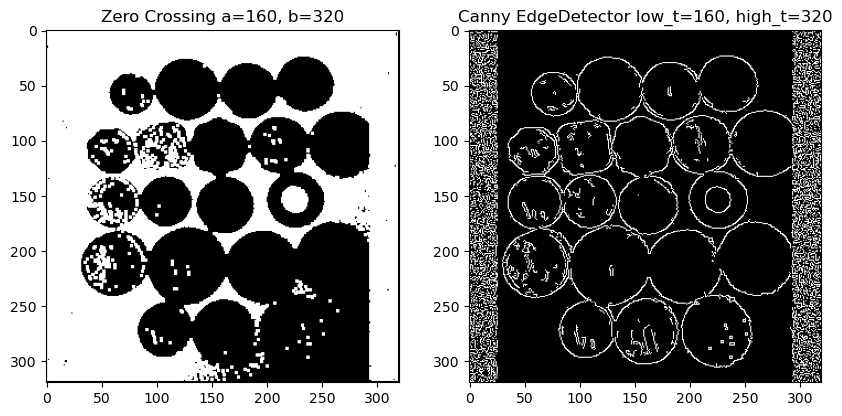

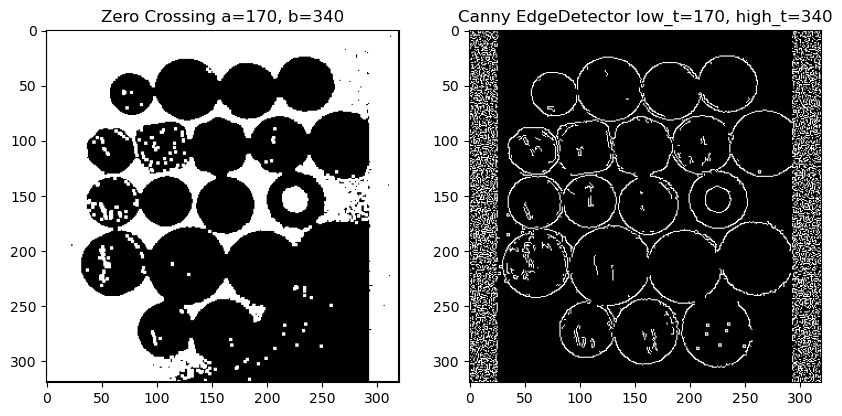

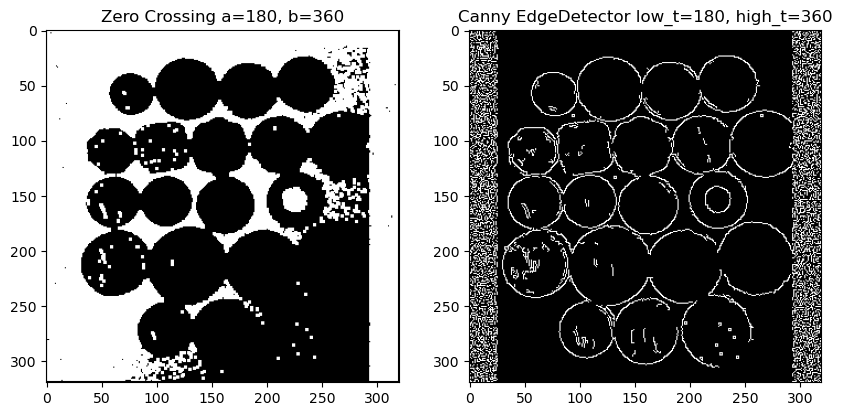

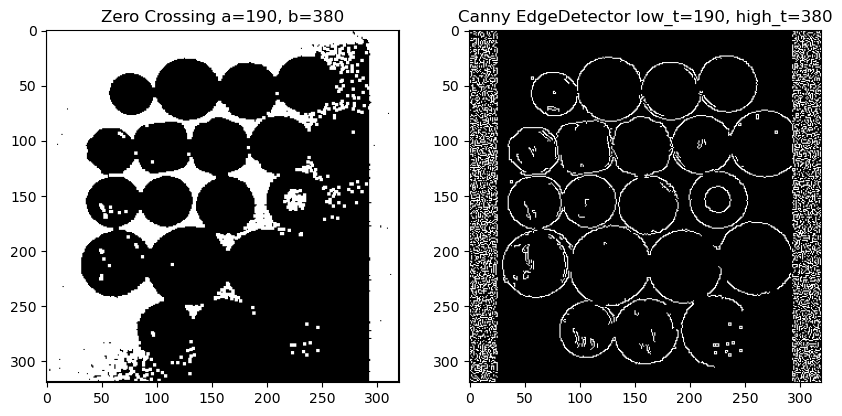

In [ ]:
for i in range(100,200,10):
    plot_canny_zc(i,2*i)

# Question 3 - Hough Transform

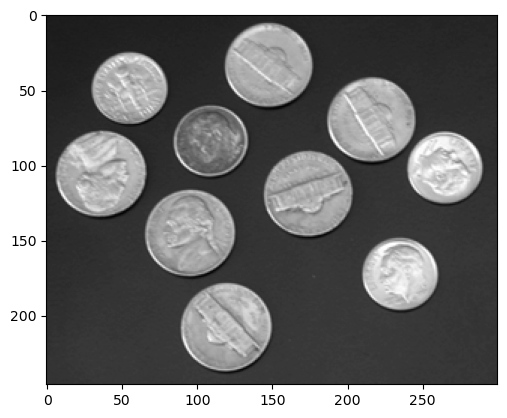

In [ ]:
# Step 0: Read the image in grayscale
img = cv2.imread('coins_Hough.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

In [ ]:
def gaussian_kernel(size, sigma=1):
    kernel = np.fromfunction(lambda x, y: (1/(2*np.pi*sigma**2)) * np.exp(-((x-size//2)**2 + (y-size//2)**2)/(2*sigma**2)), (size, size))
    return kernel / np.sum(kernel)

def sobel_filters(img):
    Gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Gy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    img_x = convolve(img, Gx)
    img_y = convolve(img, Gy)

    return img_x, img_y

def gradient_magnitude(img_x, img_y):
    return np.sqrt(img_x**2 + img_y**2)

def non_maximum_suppression(magnitude, direction):
    height, width = magnitude.shape
    suppressed = np.zeros(magnitude.shape)

    angle = direction * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            q = 255
            r = 255

            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                q = magnitude[i, j+1]
                r = magnitude[i, j-1]
            elif (22.5 <= angle[i,j] < 67.5):
                q = magnitude[i+1, j-1]
                r = magnitude[i-1, j+1]
            elif (67.5 <= angle[i,j] < 112.5):
                q = magnitude[i+1, j]
                r = magnitude[i-1, j]
            elif (112.5 <= angle[i,j] < 157.5):
                q = magnitude[i-1, j-1]
                r = magnitude[i+1, j+1]

            if magnitude[i,j] >= q and magnitude[i,j] >= r:
                suppressed[i,j] = magnitude[i,j]
            else:
                suppressed[i,j] = 0

    return suppressed

def hysteresis_thresholding(image, low_threshold_ratio=0.05, high_threshold_ratio=0.09):
    high_threshold = np.max(image) * high_threshold_ratio
    low_threshold = high_threshold * low_threshold_ratio

    strong_edges = (image >= high_threshold)
    weak_edges = (image <= high_threshold) & (image >= low_threshold)

    edges = np.zeros(image.shape)
    edges[strong_edges] = 255

    # Check weak edges connected to strong edges
    for i in range(1, image.shape[0]-1):
        for j in range(1, image.shape[1]-1):
            if weak_edges[i, j]:
                if np.sum(strong_edges[i-1:i+2, j-1:j+2]) > 0:
                    edges[i, j] = 255

    return edges

def canny_edge_detector(image, sigma=1, low_threshold_ratio=0.05, high_threshold_ratio=0.09):
    # Step 1: Noise Reduction (Gaussian Blur)
    blurred_image = ndimage.filters.gaussian_filter(image, sigma)

    # Step 2: Gradient Calculation (Sobel Filter)
    img_x, img_y = sobel_filters(blurred_image)

    # Step 3: Gradient Magnitude Calculation
    magnitude = gradient_magnitude(img_x, img_y)

    # Step 4: Non-Maximum Suppression
    direction = np.arctan2(img_y, img_x)
    suppressed = non_maximum_suppression(magnitude, direction)

    # Step 5: Double Thresholding
    edges = hysteresis_thresholding(suppressed, low_threshold_ratio, high_threshold_ratio)

    return edges



In [ ]:


def gaussian_kernel(size, sigma):
    kernel = np.fromfunction(lambda x, y: (1/(2*np.pi*sigma**2)) * np.exp(-((x-size//2)**2 + (y-size//2)**2)/(2*sigma**2)), (size, size))
    return kernel / np.sum(kernel)

def laplacian_of_gaussian(image, sigma=1):
    # Step 1: Apply Gaussian smoothing
    blurred_image = ndimage.filters.gaussian_filter(image, sigma)

    # Step 2: Apply Laplacian filter
    laplacian_kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    laplacian_response = convolve(blurred_image, laplacian_kernel)

    return laplacian_response

def zero_crossings(image):
    height, width = image.shape
    zero_crossings = np.zeros(image.shape, dtype=bool)

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            neighbors = [image[i-1, j], image[i+1, j], image[i, j-1], image[i, j+1],
                         image[i-1, j-1], image[i-1, j+1], image[i+1, j-1], image[i+1, j+1]]
            if any(np.sign(image[i, j]) != np.sign(neighbor) for neighbor in neighbors):
                zero_crossings[i, j] = True

    return zero_crossings

def LoG_edge_detector(image, sigma=1, threshold=0.1):
    # Step 1: Apply Laplacian of Gaussian
    log_response = laplacian_of_gaussian(image, sigma)

    # Step 2: Find zero crossings
    edges = zero_crossings(log_response)

    # Step 3: Apply thresholding
    edges = (np.abs(log_response) > threshold) * 255

    return edges.astype(np.uint8)




**We chose the canny edge detecting algorithm because of several reasons:**
1. It uses a gaussian filter in order to smooth the image and remove some noise. This helps remove unwanted artifacts from the image and also makes the hough transform run faster because there are less edge points
2. It takes into considration only edge points that pass a certain threshold in terms of contrast, thus removing "weak" edge points.

**The parameters** where chosen as such in order to create an edge map that shows all the coin perimeters as edge points but ignores their insides, because we would like to perform circle detection in the next step.

/var/folders/bq/_08z9_fd2dd1rg5kfblv2f4c0000gn/T/ipykernel_12581/3204696534.py:70: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  blurred_image = ndimage.filters.gaussian_filter(image, sigma)
/var/folders/bq/_08z9_fd2dd1rg5kfblv2f4c0000gn/T/ipykernel_12581/1763663502.py:7: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  blurred_image = ndimage.filters.gaussian_filter(image, sigma)


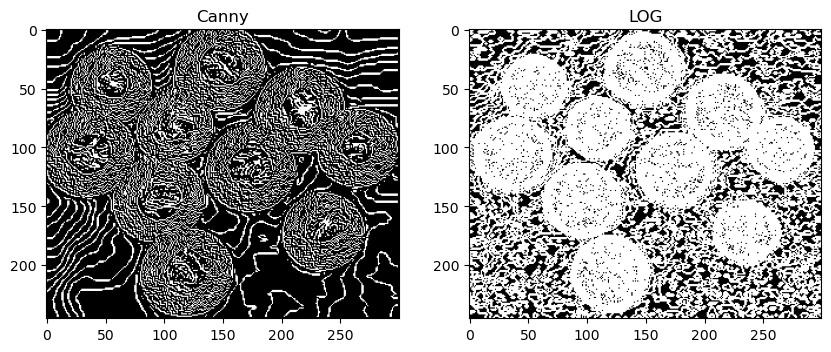

In [ ]:
def edgeDetector(image):
  '''
  This function should get as input the grayscale 'image' and any additional
  parameters you need, and return 'edge_map': a binary image (same shape as 'image')
  with a value of 1 in each detected edge pixel and a value of zero otherwise.
  '''
  edge_map = cv2.Canny(image,100,600)
  return edge_map

# Step 1: Produce an edge map from the image using an edge detector
edges = edgeDetector(img)
plt.imshow(edges, cmap='gray')

**We chose the following parameters:**
1. **minRadius = 10, maxRadius = 50** -> all of the circles in the image are included in this radius range.
2. **threshold = 10** -> chosen as such
because the coins aren't "perfect" circles and we check 360/20=18 angles, so 10 points on the perimeter should be enough to determine a circle in the image
3. **minDist = 10** -> we didn't want multiple circles detected on the same coin, which can happen becuase again, they aren't perfect circles. But, the distance between coins is fairly low so 10 was the right balance.

In [ ]:
def HoughCircles(edge_map):
  '''
  This function should get as input binary edge map and any additional
  parameters needed to compute the Hough space and to find the local maximums.
  It should first compute the Hough space, i.e. the votes of each edge pixel
  for all the relevant circles passing by it. Then, it should detect the local
  maximum points which are equivalent to detecting the circles in the image.
  The algorithm should return the parameters representing the detected circles.
  Note: you must explain any additional input and\or output parameters to this algorithm
  in your attached pdf file.
  '''

  minRadius = 10
  maxRadius = 50
  threshold = 10
  minDist = 10
  # Apply Hough Transform to detect circles
  circles = []
  rows, cols = edge_map.shape
  accumulator = np.zeros((rows, cols, maxRadius), dtype=np.uint64)

  for y in range(rows):
      for x in range(cols):
          # If the pixel is an edge pixel
          if edges[y, x] > 0:
              # Test different radii
              for r in range(minRadius, maxRadius):
                  # Vote for circle centers using the parametric equation of a circle
                  for theta in range(0, 360, 20):
                      a = int(x - r * np.cos(np.deg2rad(theta)))
                      b = int(y - r * np.sin(np.deg2rad(theta)))
                      if a >= 0 and a < cols and b >= 0 and b < rows:
                          accumulator[b, a, r] += 1

  # Find circles from accumulator
  for r in range(minRadius, maxRadius):
      for y in range(rows):
          for x in range(cols):
              if accumulator[y, x, r] >= threshold:
                 if all(np.sqrt((x - c[0])**2 + (y - c[1])**2) >= minDist for c in circles):
                        circles.append((x, y, r))

  return circles

# Step 2: Detect circles in the image using Hough transform
circles = HoughCircles(edges)

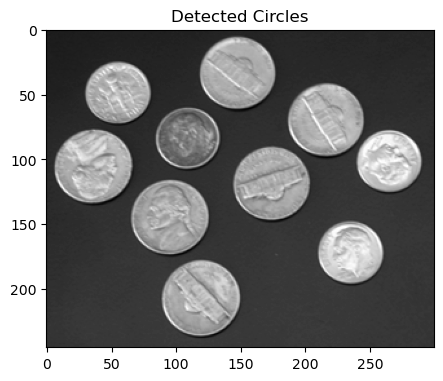

In [ ]:
def plotCircles(image):
  '''
  This function should plot the detected circles.
  It should draw the circles on top of the original grayscale image.
  You must add to this function parameters representing the detected circles
  that should be drawn.
  '''
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
  ax.imshow(image, cmap="gray")
  ax.title.set_text("Detected Circles")

  for circle in circles:
    circ = plt.Circle((circle[0], circle[1]), circle[2], color='b', linewidth=2, fill=False)
    ax.add_artist(circ)

  ax.axis('image')
  plt.show()

# Step 3: Plot the detected circles on top of the original image
plotCircles(img)